In [87]:
import os # for OS related dependencies
import pathlib

import numpy as np # linear algebra

import matplotlib.pyplot as plt # data visualization

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import get_file
from keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.optimizers import SGD




In [88]:
image_size = (224,224,3) #recommended size of the image of mobilenetV2 
batch_size = 32
number_classes = 8 # 8 classes in the Kvasir-data set
epochs = 15

# get all classes for this dataset
path ='kvasir-dataset' 
kvasir = pathlib.Path(path)
class_names = np.array([item.name for item in kvasir.glob('*')])

image_gen = ImageDataGenerator(rescale=1./255,
                               validation_split = 0.2,
                               rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest'
                              )

train_data = image_gen.flow_from_directory(
    directory ="kvasir-dataset",
    classes = list(class_names),
    subset="training",
    seed=1337,
    target_size=(image_size[0],image_size[1]),
    batch_size=batch_size,
)
val_data = image_gen.flow_from_directory(
    directory = "kvasir-dataset",
    classes = list(class_names),
    subset="validation",
    seed=1337,
    target_size=(image_size[0],image_size[1]),
    batch_size=batch_size,
)


Found 3200 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


In [89]:
#create our own model using MobileNetV2
#MobileNetV2 model is pre trained for classify 1000 different classes
#So we have to tune the model so it can suitable for our image classification

def create_model(input_shape):
    # load MobileNetV2
    model = keras.applications.MobileNetV2(input_shape=input_shape,include_top = False)
    
    for layer in model.layers[:-4]:
        layer.trainable = False
    for layer in model.layers[-4:]:
        layer.trainable = True
    
    dropout1 = Dropout(0.6)
    
    x = model.output
    x= GlobalAveragePooling2D()(x)
    x=dropout1(x)
    
    x = Dense(256,activation ='relu')(x)

    predictions = Dense(8,activation = 'softmax')(x)
    
    model = Model(inputs=model.inputs, outputs=predictions)
    # freeze all the weights of the model except the last 4 layers
    
   
    
    # print the summary of the model architecture
    model.summary()
    # training the model using rmsprop optimizer
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [90]:
#Training the model
model_name = "AlphaGo classifier"
model = create_model(image_size)

train_generator, validation_generator, class_names = train_data,val_data,class_names

# some nice callbacks
tensorboard = TensorBoard(log_dir=f"logs/{model_name}")
#checkpoint = ModelCheckpoint(f"results/{model_name}" + "-loss-{val_loss:.2f}-acc-{val_acc:.2f}.h5",
                                #save_best_only=True,
                               # verbose=1)
checkpoint = ModelCheckpoint("-loss-{val_loss:.2f}-acc-{val_acc:.2f}.h5")
# make sure results folder exist
#if not os.path.isdir("results"):
    #os.mkdir("results")
# count number of steps per epoch
training_steps_per_epoch = np.ceil(train_generator.samples / batch_size)
validation_steps_per_epoch = np.ceil(validation_generator.samples / batch_size)

#Add early stoping to reduce overfitting
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_14[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
___________________________________________________________________________________________

In [91]:
# train using the generators
model.fit_generator(train_generator,steps_per_epoch=training_steps_per_epoch,
        validation_data=validation_generator, validation_steps=validation_steps_per_epoch,
        epochs=epochs, verbose=1,callbacks=[tensorboard])


Epoch 1/15
100/100 [==============================] - 143s 1s/step - loss: 1.0816 - accuracy: 0.6113 - val_loss: 0.5297 - val_accuracy: 0.8112
Epoch 2/15
100/100 [==============================] - 138s 1s/step - loss: 0.5257 - accuracy: 0.8093 - val_loss: 0.8219 - val_accuracy: 0.7425
Epoch 3/15
100/100 [==============================] - 140s 1s/step - loss: 0.4985 - accuracy: 0.8068 - val_loss: 0.7928 - val_accuracy: 0.7613
Epoch 4/15
100/100 [==============================] - 133s 1s/step - loss: 0.3999 - accuracy: 0.8442 - val_loss: 0.5520 - val_accuracy: 0.8100
Epoch 5/15
100/100 [==============================] - 139s 1s/step - loss: 0.3716 - accuracy: 0.8560 - val_loss: 0.5445 - val_accuracy: 0.8075
Epoch 6/15
100/100 [==============================] - 143s 1s/step - loss: 0.3259 - accuracy: 0.8597 - val_loss: 0.4901 - val_accuracy: 0.8338
Epoch 7/15
100/100 [==============================] - 138s 1s/step - loss: 0.3628 - accuracy: 0.8587 - val_loss: 0.4759 - val_accuracy: 0.8300

In [ ]:
#save the model
model.save_weights('0.8500-val.h5')

#evalute the model using validation data set
results = model.evaluate(validation_generator,batch_size=batch_size)
print("[Result] [Error, Accuracy] : ",results)




22/25 [=========================>....] - ETA: 3s - loss: 0.3868 - accuracy: 0.8622

In [92]:
#load the tensorboard
%load_ext tensorboard
%reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [93]:

%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 117906), started 12:22:11 ago. (Use '!kill 117906' to kill it.)

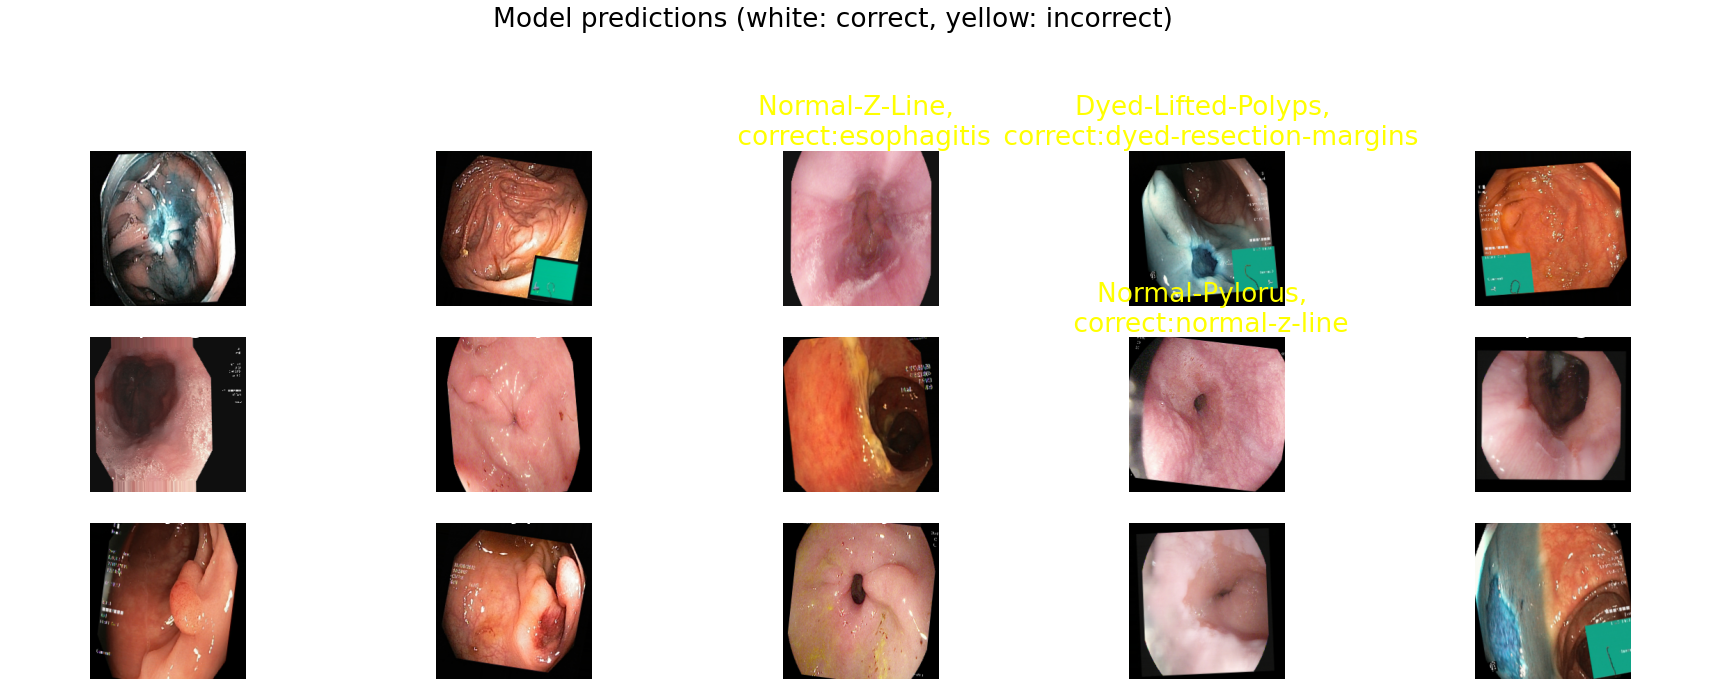

In [35]:
# get a random batch of images
image_batch, label_batch = next(iter(validation_generator))
# turn the original labels into human-readable text
label_batch = [class_names[np.argmax(label_batch[i])] for i in range(batch_size)]
# predict the images on the model
predicted_class_names = model.predict(image_batch)
predicted_ids = [np.argmax(predicted_class_names[i]) for i in range(batch_size)]
# turn the predicted vectors to human readable labels
predicted_class_names = np.array([class_names[id] for id in predicted_ids])
# some nice plotting


plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(30,20))

for n in range(15):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.2)
    plt.imshow(image_batch[n])
    if predicted_class_names[n] == label_batch[n]:
        color = "white"
        title = predicted_class_names[n].title()
    else:
        color = "yellow"
        title = f"{predicted_class_names[n].title()}, \n correct:{label_batch[n]}"
    plt.title(title, color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (white: correct, yellow: incorrect)")
plt.show()